In [ ]:
Threads.nthreads()

In [ ]:
using Symbolics

In [ ]:
@variables t
@variables U(t)
U

In [ ]:
typeof(t)

In [ ]:
function f()
    @variables Y[1:10]
    return Y
end

Z = f()[1]

In [ ]:
using Catalyst, Symbolics
include("../src/SynthEvo.jl")
C = SynthEvo.make_FullyConnectedNonExplosive_CRN(3)
println("done")

In [ ]:
using Plots

In [ ]:
function run_with_fixed_perturbations(crn, state0, control, parameters, input, perturbation_list, t0, t1, reltol=1e-12, abstol=1e-12)
    condition = [t0]
    solutions = Array{Any}(undef, length(perturbation_list))
    prob = ODEProblem(crn, vcat(state0..., control...), (0., t1), parameters, check_length=false)

    Threads.@threads for i in 1:length(perturbation_list)
        function affect!(integrator)
            integrator[:U] = max(0., input + perturbation_list[i])
        end
        ps_cb = PresetTimeCallback(condition, affect!)
        sol = solve(prob, Tsit5(), reltol=reltol, abstol=abstol, callback=ps_cb)
        solutions[i] = sol
    end
    return solutions
end

perturbation_list = [0.1, 0.2, 0.3, 0.4, 0.5]

solutions = run_with_fixed_perturbations(C.ode, [0. for i in 1:3], [0.], [rand() for _ in 1:80], 1., perturbation_list, 5., 10.)

plot(solutions[1], label="0.1", idxs=1:4)

In [ ]:
perturbation_list = [rand() for _ in 1:10000]

input = 1
u0 = [0. for _ in 1:243]
control0 = [input]
p0 = [rand() for _ in 1:80]
t0 = 5.
t1 = 10.
base_problem = SynthEvo.make_base_problem(C, C.ext_ode, u0, control0, p0, t0, true, 0.1)
println("done")

In [ ]:
using Plots

In [ ]:
shared_solution, solutions = SynthEvo.run_SF_CPU(C, base_problem, t0, t1, perturbation_list, 1e-5, 1e-5, true, 0.25)
println("done")
colors = get_color_palette(:auto, plot_color(:white))

# plot(shared_solution, idxs=1:3, label=false)
# for i in 1:length(solutions)
#     plot!(solutions[i], idxs=1:3, label=false, color=colors[(i+3) % length(colors) + 1])
# end
# plot!()
# xlims!(0., 10.)

In [ ]:
parameter_sets = [[rand() for _ in 1:80] for _ in 1:1]
@time solutions = SynthEvo.runp_SF_CPU(C, base_problem, parameter_sets, t0, t1, perturbation_list, 1e-5, 1e-5, true, 0.25)
println("done")
colors = get_color_palette(:auto, plot_color(:white))

# plot()
# for i in 1:length(solutions)
#     plot!(solutions[i][1], idxs=1:3, label=false)
#     for j in 1:length(solutions[i][2])
#         plot!(solutions[i][2][j], idxs=1:3, label=false, color=colors[(j+3) % length(colors) + 1])
#     end
# end
# plot!()
# xlims!(0., 10.)

In [ ]:
reduced_base_problem = SynthEvo.make_base_problem(C, C.ode, u0[1:3], control0, p0, t0, false, 5)
@time solutions = SynthEvo.runp_SF_CPU(C, C.ode, reduced_base_problem, parameter_sets, t0, t1, perturbation_list, 1e-5, 1e-5, false, 5)
println("done")

### GPU stuff

In [ ]:
using CUDA, StaticArrays, DiffEqGPU

function run_CUDA(ode, state0, control0, parameters, t_shared, t_unique, controls, reltol=1e-12, abstol=1e-12, verbose=true, where0=nothing, where1=nothing)
    condition = [t_shared]
    solutions = Array{Any}(undef, length(perturbation_list))
    shared_problem = ODEProblem(ode, cu(vcat(state0..., control0...)), (0., t_shared), cu(parameters), check_length=false, saveat=verbose ? true : where0, save_everystep=verbose)
    shared_solution = solve(shared_problem, Tsit5(), reltol=reltol, abstol=abstol)

    problem = ODEProblem(ode, cu(shared_solution.u[end]), (t_shared, t_unique), cu(parameters), check_length=false, saveat=verbose ? true : where1, save_everystep=verbose)
    for i in 1:length(controls)
        problem = remake(problem, u0=cu(vcat(shared_solution.u[end][1:length(state0)], controls[i]...)))
        sol = solve(problem, Tsit5(), reltol=reltol, abstol=abstol)
        solutions[i] = sol
    end
    return (shared_solution, solutions)
end

perturbation_list = [2, 3]

input = 1
shared_solution, solutions = run_CUDA(C.ode, [0. for _ in 1:3], [input], [rand() for _ in 1:80], 5., 10., perturbation_events(1., perturbation_list), 1e-5, 1e-5, true, 0.25, 0.25)
println("done")
colors = get_color_palette(:auto, plot_color(:white))

plot(shared_solution, idxs=1:3, label=false)
for i in 1:length(solutions)
    plot!(solutions[i], idxs=1:3, label=false, color=colors[i+3])
end
plot!()
xlims!(0., 10.)

In [ ]:
using DiffEqGPU, CUDA, StaticArrays, Setfield

function lorenz(u, p, t)
    σ = p[1]
    ρ = p[2]
    β = p[3]
    out = @SVector Float32[0, 0, 0]
    @set! out[1] = σ * (u[2] - u[1])
    @set! out[2] = u[1] * (ρ - u[3]) - u[2]
    @set! out[3] = u[1] * u[2] - β * u[3]
    return out
end

u0 = @SVector [1.0f0; 0.0f0; 0.0f0]
tspan = (0.0f0, 10.0f0)
p = @SVector [10.0f0, 28.0f0, 8 / 3.0f0]
prob = ODEProblem{false}(lorenz, u0, tspan, p)
prob_func = (prob, i, repeat) -> remake(prob, p = (@SVector rand(Float32, 3)) .* p .+ i)
monteprob = EnsembleProblem(prob, prob_func = prob_func, safetycopy = false)

@time sol = solve(monteprob, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()),
    trajectories = 10_000, adaptive = false, dt = 0.1f0)

In [ ]:
using ModelingToolkit, Cthulhu

In [ ]:
C.ode

In [ ]:
using CUDA, StaticArrays, DiffEqGPU


function run_CUDAensamble(ode, state0, control0, parameters, t_shared, t_unique, controls, reltol=1e-12, abstol=1e-12, verbose=true, where0=nothing, where1=nothing)
    condition = [t_shared]
    t_shared = convert(Float32, t_shared)
    t_unique = convert(Float32, t_unique)

    u0 = arr2svec(vcat(state0..., control0...))
    println(typeof(u0))
    
    shared_problem = ODEProblem{false}(ode, u0, (convert(Float32, 0.), convert(Float32, t_shared)), arr2svec(parameters), saveat=verbose ? true : where0, save_everystep=verbose)
    shared_solution = solve(shared_problem, GPUTsit5(), reltol=reltol, abstol=abstol)


    problem = ODEProblem{false}(ode, arr2svec(shared_solution.u[end]), (t_shared, t_unique), (parameters), check_length=false, saveat=verbose ? true : where1, save_everystep=verbose)
    problem_func = (problem, i, repeat) -> remake(problem, p = arr2svec(vcat(shared_solution.u[end][1:C.N], controls[i]..., shared_solution.u[end][C.N+length([controls[i]...])+1:end])))
    multi_problem = EnsembleProblem(problem, prob_func = problem_func, safetycopy = false)
    solutions = solve(multi_problem, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()), trajectories = length(controls), adaptive = true, reltol=1e-3, abstol=1e-3)

    return (shared_solution, solutions)
end

perturbation_list = [2, 3, 4, 5]

input = 1

shared_solution, solutions = run_CUDAensamble(C.ode, [0. for _ in 1:3], [input], [rand() for _ in 1:80], 5., 10., perturbation_events(1., perturbation_list), 1e-5, 1e-5, true, 0.25, 0.25)

println("done")
colors = get_color_palette(:auto, plot_color(:white))

plot(shared_solution, idxs=1:3, label=false)
for i in 1:size(solutions, 1)
    plot!(solutions[i], idxs=1:3, label=false, color=colors[i+3])
end
plot!()
xlims!(0., 10.)

In [ ]:
using Catalyst, Symbolics, Plots, DifferentialEquations
include("../src/SynthEvo.jl")
C = SynthEvo.make_FullyConnectedNonExplosive_CRN(3)
println("done")


function perturbation_events(input, perturbation_list)
    return [[input + rand()*p - p/2] for p in perturbation_list]
end

function arr2svec(arr)
    return SVector{length(arr), Float32}(convert(Array{Float32}, arr))
end

using CUDA, StaticArrays, DiffEqGPU

In [ ]:
function make_alternative_ode(C)
    """
    Extend the ODE system with the sensitivity equations.

    Args:
    - `C`: the CRN model

    Returns:
    - the sensitivity ODE system
    """

    S = SynthEvo.sensitivity(C)

    D = Differential(C.time)
    # convert to ODESystem
    eqs = []
    for i in 1:length(equations(C.ode))
        push!(eqs, equations(C.ode)[i])
    end
    # push!(eqs, D(C.control) ~ Num(0))
    for i in 1:size(S,1)
        for j in 1:size(S,2)
            # if isequal(S[i,j], Num(0))
            #     continue
            # end
            if i==1 && j<10
                push!(eqs, D(C.sensitivity_variables[i,j]) ~ Num(0.))
            end
        end
    end
    # convert eqs to an SVector
    eqs = SVector{length(eqs), typeof(eqs[1])}(eqs)
    return @named senesitivity_ode = ODESystem(eqs, C.time)
end

In [ ]:

function run_CUDAensamble(C, ode, state0, control0, parameters, t_shared, t_unique, controls, reltol=1e-12, abstol=1e-12, where0=nothing, where1=nothing)
    condition = [t_shared]
    t_shared = convert(Float32, t_shared)
    t_unique = convert(Float32, t_unique)

    u0 = arr2svec(vcat(state0..., control0...))
    p0 = arr2svec(parameters)
    
    shared_problem = ODEProblem(ode, u0, (0., t_shared), p0, saveat=where0)
    shared_solution = solve(shared_problem, GPUTsit5(), reltol=reltol, abstol=abstol, saveat=where0)

    problem = ODEProblem(ode, u0, (t_shared, t_unique), p0)
    
    function change_control(u0, new_control)
        U = arr2svec(vcat(u0[1:C.N], new_control..., u0[C.N+length([new_control...])+1:end]))
        return U
    end

    problem_func = (problem, i, repeat) -> remake(problem, u0=change_control(shared_solution.u[end], controls[i]))

    multi_problem = EnsembleProblem(problem; prob_func = problem_func, safetycopy = false)

    #solutions = solve(multi_problem, Tsit5(), EnsembleGPUArray(CUDA.CUDABackend()), trajectories=1000, adaptive = true, reltol=1e-7, abstol=1e-7) # this works
    solutions = solve(multi_problem, GPUTsit5(),  EnsembleGPUKernel(CUDA.CUDABackend()), trajectories=length(controls), adaptive = true, reltol=1e-7, abstol=1e-7,
    saveat=where1)

    return (shared_solution, solutions)
end

n_inpt = 10
perturbation_list = 1 .+ rand(n_inpt)

input = 1

@time shared_solution, solutions = run_CUDAensamble(C, make_alternative_ode(C), [0. for _ in 1:12], [input], [rand() for _ in 1:80], 5., 10., perturbation_list, 1e-5, 1e-5, 0.1, 0.1)
nothing
println("done")
colors = get_color_palette(:auto, plot_color(:white))

plot(shared_solution, idxs=1:3, label=false)
for i in 1:min(10, size(solutions)[end])
    plot!(solutions[i], idxs=1:3, label=false, color=colors[(i+3)%16 + 1])
end
plot!()
xlims!(0., 10.)
ylims!(0., 2.)

In [ ]:
println("done")
colors = get_color_palette(:auto, plot_color(:white))

plot(shared_solution, idxs=1:3, label=false)
for i in 1:min(10, size(solutions)[end])
    plot!(solutions[i], idxs=1:3, label=false, color=colors[(i+3)%16 + 1])
end
plot!()
xlims!(0., 10.)
ylims!(0., 2.)

In [ ]:
using Catalyst, Plots, DifferentialEquations, CUDA, StaticArrays, DiffEqGPU
rs = @reaction_network begin
  c1, S + E --> SE
  c2, SE --> S + E
  c3, SE --> P + E
end

p = [1.0, 1.0, 1.0]
u0 = [1.0, 1.0, 1.0, 1.0]
tspan = (0.0, 10.0)
ode = convert(ODESystem, rs)
prob = ODEProblem{false}(ode, u0, tspan, p)
sol = solve(prob, Tsit5(), saveat=0.1)
plot(sol, idxs=1:3)

problem_func = (problem, i, repeat) -> remake(problem, u0=rand(4))

multi_problem = EnsembleProblem(prob, prob_func = problem_func, safetycopy = false)

solutions = solve(multi_problem, GPUTsit5(), EnsembleGPUArray(CUDA.CUDABackend()), trajectories=2, adaptive = true, reltol=1e-6, abstol=1e-6)

for s in solutions
    plot!(s, idxs=1:3, linestyle=:dash, legend=false)
end
plot!()

In [ ]:
solutions

In [ ]:
colors = get_color_palette(:auto, plot_color(:white))

plot(shared_solution, idxs=1:3, label=false)
for i in 1:size(solutions)[end]
    println(i)
    plot!(solutions[i], idxs=1:3, label=false, color=colors[i+3])
end
plot!()
xlims!(0., 10.)
ylims!(0., 2.)

In [ ]:
size(solutions)

In [ ]:
v = [0. for _ in 1:3]

function arr2svec(arr)
    return SVector{length(arr), Float32}(convert(Array{Float32}, arr))
end

arr2svec(v)

In [ ]:
using CUDA, StaticArrays, DiffEqGPU

function run_CUDAensamble(ode, state0, control0, parameters, t_shared, t_unique, controls, reltol=1e-12, abstol=1e-12, verbose=true, where0=nothing, where1=nothing)
    condition = [t_shared]
    solutions = Array{Any}(undef, length(perturbation_list))
    shared_problem = ODEProblem(ode, cu(vcat(state0..., control0...)), (0., t_shared), cu(parameters), check_length=false, saveat=verbose ? true : where0, save_everystep=verbose)
    shared_solution = solve(shared_problem, Tsit5(), reltol=reltol, abstol=abstol)


    problem = ODEProblem(ode, cu(shared_solution.u[end]), (t_shared, t_unique), cu(parameters), check_length=false, saveat=verbose ? true : where1, save_everystep=verbose)
    problem_func = (prob, i, repeat) -> remake(prob, p = vcat(shared_solution.u[end][1:length(state0)], controls[i]...))
    monteprob = EnsembleProblem(prob, prob_func = prob_func, safetycopy = false)
    solutions = solve(monteprob, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()), trajectories = length(controls), adaptive = true, reltol=1e-3, abstol=1e-3)

    return (shared_solution, solutions)
end

perturbation_list = [2, 3, 4, 5]

input = 1
shared_solution, solutions = run_CUDAensamble(C.ode, [0. for _ in 1:3], [input], [rand() for _ in 1:80], 5., 10., perturbation_events(1., perturbation_list), 1e-5, 1e-5, true, 0.25, 0.25)
println("done")
colors = get_color_palette(:auto, plot_color(:white))

plot(shared_solution, idxs=1:3, label=false)
for i in 1:size(solutions, 1)
    plot!(solutions[i], idxs=1:3, label=false, color=colors[i+3])
end
plot!()
xlims!(0., 10.)

In [ ]:
size(solutions, 1)

### LOSSES

In [1]:
using Catalyst, Symbolics, Plots, DifferentialEquations
include("../src/SynthEvo.jl")
C = SynthEvo.make_FullyConnectedNonExplosive_CRN(3)
println("done")


function perturbation_events(input, perturbation_list)
    return [[input + rand()*p - p/2] for p in perturbation_list]
end

function arr2svec(arr)
    return SVector{length(arr), Float32}(convert(Array{Float32}, arr))
end

using CUDA, StaticArrays, DiffEqGPU

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Module Symbolics with build ID ffffffff-ffff-ffff-0000-508b0a695c57 is missing from the cache.
│ This may mean Symbolics [0c5d862f-8b57-4792-8d23-62f2024744c7] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
┌ Warning: Module Symbolics with build ID ffffffff-ffff-ffff-0000-508b0a695c57 is missing from the cache.
│ This may mean Symbolics [0c5d862f-8b57-4792-8d23-62f2024744c7] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
┌ Warning: Module Symbolics with build ID ffffffff-ffff-ffff-0000-508b0a6

done


In [155]:
function loss_wrapper(expression, parameters, times)
    """
    Add automatic differentiation to the loss function.
    """
    dx = der_(expression, parameters)

    fun = eval(build_function(expression, parameters))
    fun_dx = [eval(eval(build_function(dxi, parameters))[1]) for dxi in dx]

    loss = (fun=fun, fun_dx=fun_dx, expr=expression, parameters=parameters)

    sub = (parameters) -> sub_(loss, parameters)

    loss = (fun=fun, fun_dx=fun_dx, expr=expression, parameters=parameters, sub = sub, times=times)

    return loss
end

function adaptation_loss(C, norm, target, t0, t1)
    """
    Compute the error of the adaptation. 
    This is the difference of the change in the target species at the two fix points.

    > parameters: X_0, X_1 state at t0 and t1

    Args:
    - `norm`: the norm to use

    Returns:
    - expression/variables pair
    """
    @parameters X_0[1:C.N] X_1[1:C.N]
    if norm == 1
        expression = X_1[target]^2#abs(X_1[target] - 2) #+ abs(X_0[target] - 1)
    else
        expression = (X_1[target] - X_0[target])^norm
    end
    parameters = [X_0, X_1]
    times = [t0, t1]
    return loss_wrapper(expression, parameters, times)
end

function steady_state_loss(C, norm, t0, t1, t0mdt, t1mdt)
    """
    Compute the error of the adaptation. 
    This is the difference of the change in the target species at the two fix points.

    > parameters: X_0, X_1, X_0mdt, X_1mdt state at t0 and t1

    Args:
    - `norm`: the norm to use

    Returns:
    - expression/variables pair
    """
    @parameters X_0[1:C.N] X_1[1:C.N] X_0mdt[1:C.N] X_1mdt[1:C.N]
    if norm == 1
        expression = abs(X_0[1] - X_0mdt[1]) + abs(X_0[2] - X_0mdt[2]) + abs(X_0[3] - X_0mdt[3]) + abs(X_1[1] - X_1mdt[1]) + abs(X_1[2] - X_1mdt[2]) + abs(X_1[3] - X_1mdt[3])
    else
        expression = (X_0[1] - X_0mdt[1])^norm + (X_0[2] - X_0mdt[2])^norm + (X_0[3] - X_0mdt[3])^norm + (X_1[1] - X_1mdt[1])^norm + (X_1[2] - X_1mdt[2])^norm + (X_1[3] - X_1mdt[3])^norm
    end
    parameters = [X_0, X_1, X_0mdt, X_1mdt]
    times = [t0, t1, t0mdt, t1mdt]
    return loss_wrapper(expression, parameters, times)
end

function sensitivity_loss(C, norm, target, min_response, t0, t0pdt)
    @parameters X_0[1:C.N] X_0pdt[1:C.N] 
    if norm == 1
        expression = abs(abs(X_0pdt[target] - X_0[target]) - min_response)
    else
        expression = (abs(X_0pdt[target] - X_0[target]) - min_response)^norm
    end
    parameters = [X_0, X_0pdt]
    times = [t0, t0pdt]
    return loss_wrapper(expression, parameters, times)
end

function regularization_loss(C, norm)
    if norm == 1
        expression = sum(abs.([C.parameters[i] for i in 1:length(C.parameters)]))
    else
        expression = sum([C.parameters[i] for i in 1:length(C.parameters)].^norm)
    end
    parameters = [C.parameters]
    times = [nothing]
    return loss_wrapper(expression, parameters, times)
end

function weighted_loss(losses, weights)
    """
    Combine multiple losses into a single loss.

    Args:
    - `losses`: a list of loss functions
    - `weights`: a list of weights

    Returns:
    - 
    """
    expression = sum([losses[i].expr * weights[i] for i in 1:length(losses)])
    parameters = unique(vcat([losses[i].parameters for i in 1:length(losses)]...))
    times = unique(vcat([losses[i].times for i in 1:length(losses)]...))
    return loss_wrapper(expression, parameters, times)
end

function eval_loss(C, loss, CRN_parameters, trajectory, compute_derivatives=true)
    loss_inputs = []
    for t in loss.times
        if t == nothing
            push!(loss_inputs, CRN_parameters)
        else
            push!(loss_inputs, trajectory(t)[1:C.N])
        end
    end
    loss_out = loss.sub(loss_inputs) # value of the loss
    if !compute_derivatives
        return (loss=loss_out.val, gradient=nothing)
    end
    sensitivities = [0. for _ in 1:length(CRN_parameters)]
    
    for i in 1:length(loss.times)
        if loss.times[i] == nothing
            sensitivities += loss_out.der[i]
        else
            loss_jac = loss_out.der[i]
            print("doing", loss.times[i], loss_jac)
            sensitivities += vec(reshape(loss_jac, 1, length(loss_jac)) * sensitivity_from_ode(C, trajectory, loss.times[i]))
        end
    end
    return (loss=loss_out.val, gradient=sensitivities)
end

function der_(expression, parameters)
    dx = [[Symbolics.derivative(expression, x_i) for x_i in x] for x in parameters]
    return dx
end

function sub_(loss, parameters, compute_derivatives=true)
    val = loss.fun(parameters)
    if !compute_derivatives
        return (val=val, der=nothing)
    end
    der = [f(parameters) for f in loss.fun_dx]
    return (val=val, der=der)
end


function sensitivity_from_ode(C::CRN, sol, t) 
    """
    Compute the sensitivity matrix at time t.

    Args:
    - `ode`: the ODE system
    - `sol`: the solution of the ODE

    Returns:
    - the sensitivity matrix
    """
    v = sol(t)
    # sensitivity matrix
    m = zeros(C.N, C.number_of_parameters)
    line = 0
    column = 0
    for i in 1:C.N
        for j in 1:C.number_of_parameters
            m[line+1,column+1] = v[ (line)*C.number_of_parameters + (column) + C.N + 1 + 1 ] # todo Multiple inputs
            line += 1
            if line == C.N
                line = 0
                column += 1
            end
        end
    end
    return m
end

function merge_solutions(shared_solution, solution, idx, t0)
    function access!(time)
        if time < t0
            return shared_solution(time)
        else
            return solution[idx](time)
        end
    end
    return access!
end


merge_solutions (generic function with 1 method)

In [156]:
x = nothing
input = 1
u0 = [0. for _ in 1:243]
control0 = [input]
p0 = [i/80 for i in 1:80]
t0 = 5.
t1 = 10.
perturbation_list = [10 for _ in 1:1]

base_problem = SynthEvo.make_base_problem(C, C.ext_ode, u0, control0, p0, t0, true, 0.1)

loss1 = adaptation_loss(C, 1, 3, 5., 10.)
loss2 = sensitivity_loss(C, 1, 3, 0.5, 5., 6)
loss3 = steady_state_loss(C, 1, 5., 10., 3, 8.)
loss4 = regularization_loss(C, 1)
l = weighted_loss([loss1, loss2, loss3, loss4], [1,0,0,0])
problem = remake(base_problem, p = p0)
shared_solution, solutions = SynthEvo.run_SF_CPU(C, problem, t0, t1, perturbation_list, 1e-5, 1e-5, true, 0.01)
sol = merge_solutions(shared_solution, solutions, 1, t0)
eval_loss(C, l, p0, sol, true)

doing5.0[0, 0, 0]doing10.0[0.0, 0.0, 2.421335570045252]doing6.0[0, 0, 0]doing3.0[0, 0, 0]doing8.0[0, 0, 0]

(loss = 1.4657164856915912, gradient = [0.24503155798218837, -0.29883258642023564, -0.020778156018697584, 0.10347644384263677, -0.22779242641748612, 0.25771960358322044, 0.024730532318959615, 0.23596123089361726, -0.4023090302628723, -0.8304313772177664  …  0.07002299548416042, -0.044852379587091776, 0.24745246899474718, -0.18548261099641664, 0.22655454944839684, 0.05053171030507231, -0.17144194732757392, -0.11882633140786716, -0.12083191639410332, -0.054393335184034476])

In [145]:
l.expr

X_1[3]

doing5.0[0, 0, 0]doing10.0[0, 0, 1]  0.126369 seconds (63.27 k allocations: 4.625 MiB)


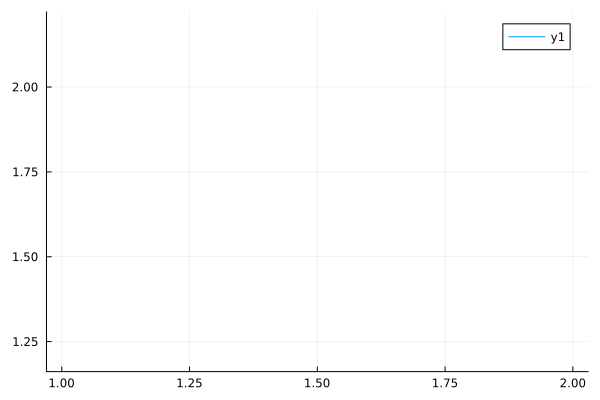

In [141]:


losses = []
sol = nothing
pars = []
log_ = []
grad_history_ada = [0. for _ in 1:80]
momentum_adam = [0. for _ in 1:80]
velocity_adam = [0. for _ in 1:80]
@time for _ in 1:1
    problem = remake(base_problem, p = p0)
    shared_solution, solutions = SynthEvo.run_SF_CPU(C, problem, t0, t1, perturbation_list, 1e-5, 1e-5, true, 0.01)
    sol = merge_solutions(shared_solution, solutions, 1, t0)
    x = eval_loss(C, loss1, p0, sol, true)
    push!(losses, x)
    #println(x.loss, " : ", x.gradient)
    lr = SynthEvo.adagrad_update_get_coefficient(p0, x.gradient, grad_history_ada, 1)
    #lr = SynthEvo.ADAM_update_get_coefficient(p0, x.gradient, momentum_adam, velocity_adam, 0.1, 0.9, 0.9, 1e-8)
    p0 = max.(0, p0 - lr.*x.gradient)
    p0 = [ i<4 ? p0[i] : 0 for i in 1:length(p0)]
    push!(pars, p0)
end
nothing
plot([l.loss for l in losses])

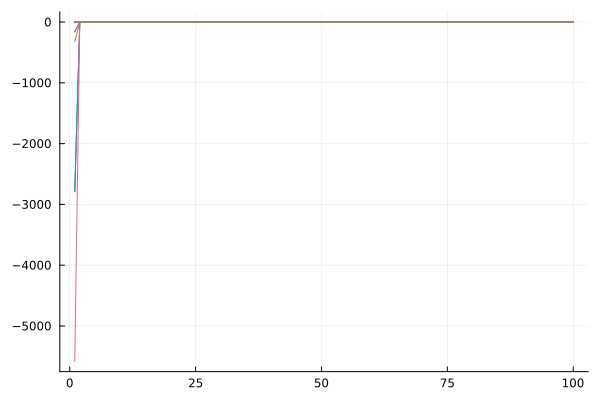

In [109]:
plot(1:length(losses), SynthEvo.vec2mat([l.gradient for l in losses]), legend=false)

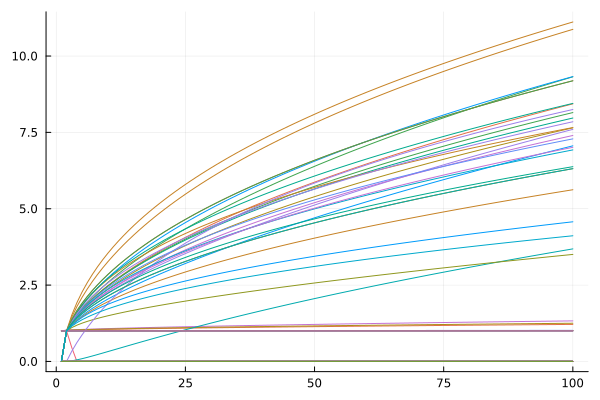

In [110]:
plot(1:length(pars), SynthEvo.vec2mat(pars), legend=false)

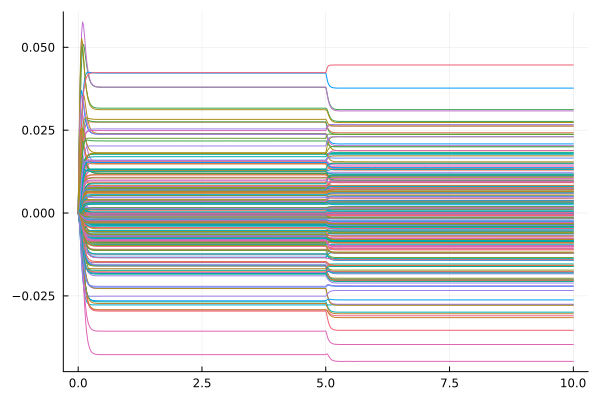

In [111]:
plot( [(t*0.01) for t in 0:1000], SynthEvo.vec2mat([sol(t*0.01)[5:end] for t in 0:1000]), legend=false)

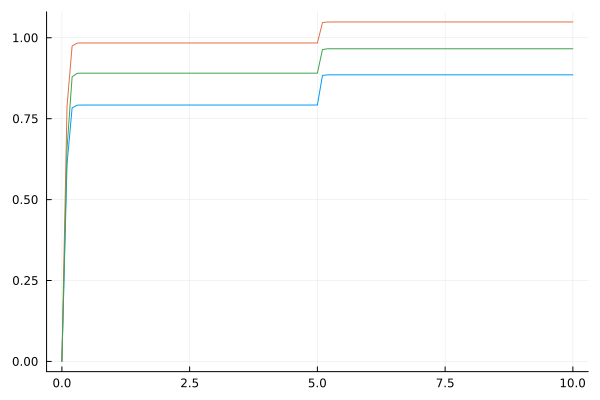

In [126]:
base_problem = SynthEvo.make_base_problem(C, C.ext_ode, u0, control0, p0, t0, true, 0.1)
shared_solution, solutions = SynthEvo.run_SF_CPU(C, base_problem, t0, t1, perturbation_list, 1e-5, 1e-5, true, 0.25)
sol = merge_solutions(shared_solution, solutions, 1, t0)
plot( [(t*0.1) for t in 0:100], SynthEvo.vec2mat([sol(t*0.1)[1:3] for t in 0:100]), legend=false)

In [ ]:
losses[1].loss

In [61]:
sensitivity_from_ode(C, sol, 10) 

3×80 adjoint(::Matrix{Float64}) with eltype Float64:
 0.00143784  0.0038801   0.00850435  …  -0.000833162  -0.000416581
 0.00879321  0.0026371   0.0103209       0.0020988     0.0010494
 0.00180613  0.00660882  0.00628297     -0.0016369    -0.000818449